In [1]:
import os
import sys
sys.path = [
    '../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master',
] + sys.path

In [2]:
sys.path = [
    '../input/ttach-kaggle/ttach/',
] + sys.path
import ttach as tta

In [3]:
import skimage.io
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from efficientnet_pytorch import model as enet

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [4]:
data_dir = '../input/prostate-cancer-grade-assessment'
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
df_test = pd.read_csv(os.path.join(data_dir, 'test.csv'))
df_sub = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

model_dir = '../input/panda-public-models'
image_folder = os.path.join(data_dir, 'test_images')
is_test = os.path.exists(image_folder)  # IF test_images is not exists, we will use some train images.
image_folder = image_folder if is_test else os.path.join(data_dir, 'train_images')

df = df_test if is_test else df_train.loc[:16]

tile_size = 256
image_size = 256
n_tiles = 36
batch_size = 4
num_workers = 4

device = torch.device('cuda')

print(image_folder)

../input/prostate-cancer-grade-assessment/train_images


In [5]:
class enetv3(nn.Module):
    def __init__(self, modelname, out_dim=5, freeze_bn=True):
        super(enetv3, self).__init__()
           
        from efficientnet_pytorch import EfficientNet
        self.basemodel = EfficientNet.from_name(modelname) 
        self.myfc = nn.Linear(self.basemodel._fc.in_features, out_dim)
        self.basemodel._fc = nn.Identity()     
        self.basemodel._avg_pooling = nn.AdaptiveAvgPool2d(1) #GeM() 

            
    def extract(self, x):
        return self.basemodel(x)

    def forward(self, x):
        x = self.basemodel(x)
        if not "eff" in modelname:
            x = self.pool(x).squeeze(2).squeeze(2)
            x = self.myfc(x)
        else:
            x = self.myfc(x)
        return x
    
def load_models(model_files):
    models = []
    for model_f in model_files:
        model_f = os.path.join("../input/latesubspanda", model_f)
        if "res" in model_f:
            model = enetv2(out_dim=5)
        elif "eff" in model_f:
            model = enetv3(modelname, out_dim=5)
        model.load_state_dict(torch.load(model_f))
        model.eval()
        model.to(device)
        models.append(model)
        print(f'{model_f} loaded!')
    return models

modelname="efficientnet-b0"

# load ensembles
model_files2 = [
    "efficientnet-b0famlabelsmodelsub_avgpool_tile36_imsize256_mixup_final_epoch20_fold0.pth",
    "efficientnet-b0famlabelsmodelsub_avgpool_tile36_imsize256_mixup_final_epoch20_fold1.pth",
    "efficientnet-b0famlabelsmodelsub_avgpool_tile36_imsize256_mixup_final_epoch20_fold2.pth",
    "efficientnet-b0famlabelsmodelsub_avgpool_tile36_imsize256_mixup_final_epoch20_fold3.pth",
    "efficientnet-b0famlabelsmodelsub_avgpool_tile36_imsize256_mixup_final_epoch20_fold4.pth"
]

models2 = load_models(model_files2)

../input/latesubspanda/efficientnet-b0famlabelsmodelsub_avgpool_tile36_imsize256_mixup_final_epoch20_fold0.pth loaded!
../input/latesubspanda/efficientnet-b0famlabelsmodelsub_avgpool_tile36_imsize256_mixup_final_epoch20_fold1.pth loaded!
../input/latesubspanda/efficientnet-b0famlabelsmodelsub_avgpool_tile36_imsize256_mixup_final_epoch20_fold2.pth loaded!
../input/latesubspanda/efficientnet-b0famlabelsmodelsub_avgpool_tile36_imsize256_mixup_final_epoch20_fold3.pth loaded!
../input/latesubspanda/efficientnet-b0famlabelsmodelsub_avgpool_tile36_imsize256_mixup_final_epoch20_fold4.pth loaded!


In [6]:
def get_tiles(img, mode=0):
        result = []
        h, w, c = img.shape
        pad_h = (tile_size - h % tile_size) % tile_size + ((tile_size * mode) // 2)
        pad_w = (tile_size - w % tile_size) % tile_size + ((tile_size * mode) // 2)

        img2 = np.pad(img,[[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2,pad_w - pad_w//2], [0,0]], constant_values=255)
        img3 = img2.reshape(
            img2.shape[0] // tile_size,
            tile_size,
            img2.shape[1] // tile_size,
            tile_size,
            3
        )

        img3 = img3.transpose(0,2,1,3,4).reshape(-1, tile_size, tile_size,3)
        n_tiles_with_info = (img3.reshape(img3.shape[0],-1).sum(1) < tile_size ** 2 * 3 * 255).sum()
        if len(img) < n_tiles:
            img3 = np.pad(img3,[[0,N-len(img3)],[0,0],[0,0],[0,0]], constant_values=255)
        idxs = np.argsort(img3.reshape(img3.shape[0],-1).sum(-1))[:n_tiles]
        img3 = img3[idxs]
        for i in range(len(img3)):
            result.append({'img':img3[i], 'idx':i})
        return result, n_tiles_with_info >= n_tiles


class PANDADataset(Dataset):
    def __init__(self,
                 df,
                 image_size,
                 n_tiles=n_tiles,
                 tile_mode=0,
                 rand=False,
                 sub_imgs=False
                ):

        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.tile_mode = tile_mode
        self.rand = rand
        self.sub_imgs = sub_imgs

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        
        tiff_file = os.path.join(image_folder, f'{img_id}.tiff')
        image = skimage.io.MultiImage(tiff_file)[1][:,:,::-1]
        tiles, OK = get_tiles(image, self.tile_mode)

        if self.rand:
            idxes = np.random.choice(list(range(self.n_tiles)), self.n_tiles, replace=False)
        else:
            idxes = list(range(self.n_tiles))
        idxes = np.asarray(idxes) + self.n_tiles if self.sub_imgs else idxes

        n_row_tiles = int(np.sqrt(self.n_tiles))
        images = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
    
                if len(tiles) > idxes[i]:
                    this_img = tiles[idxes[i]]['img']
                else:
                    this_img = np.ones((self.image_size, self.image_size, 3)).astype(np.uint8) * 255
                this_img = 255 - this_img
                h1 = h * image_size
                w1 = w * image_size
                images[h1:h1+image_size, w1:w1+image_size] = this_img
        #images = 255 - images
        images = images.astype(np.float32)
        images /= 255
        images = images.transpose(2, 0, 1)

        return torch.tensor(images)

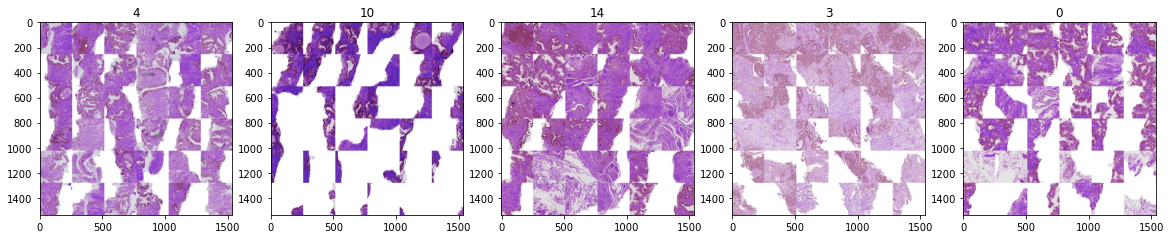

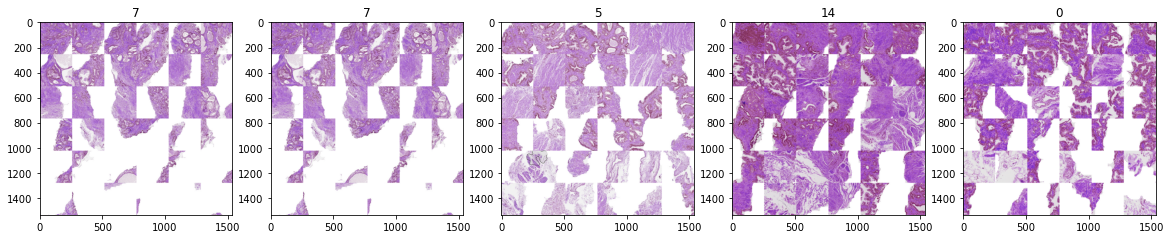

In [7]:
if not is_test:
    dataset_show = PANDADataset(df, image_size, n_tiles, 4)
    from pylab import rcParams
    rcParams['figure.figsize'] = 20,10
    for i in range(2):
        f, axarr = plt.subplots(1,5)
        for p in range(5):
            idx = np.random.randint(0, len(dataset_show))
            img = dataset_show[idx]
            axarr[p].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
            axarr[p].set_title(str(idx))

In [8]:
# Prepare tiles with different paddings, introducing slightly different tiles
dataset = PANDADataset(df, image_size, n_tiles, 0)  # mode == 0
loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

dataset2 = PANDADataset(df, image_size, n_tiles, 2)  # mode == 2
loader2 = DataLoader(dataset2, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [9]:
import ttach as tta
if len(dataset) > 50:
    transforms = tta.Compose(
        [
            tta.HorizontalFlip(),
            tta.VerticalFlip(),
            tta.Rotate90(angles=[0, 90, 180]),
        ]
    )
else:
    # For commits
    transforms = tta.Compose(
        [
            #tta.HorizontalFlip(),
        ]
    )
    
tta_models2 = []
# TTA wrappers
for model in models2:
    tta_models2.append(tta.ClassificationTTAWrapper(model, transforms))

In [10]:
LOGITS = []
LOGITS2 = []
LOGITS12 = []
LOGITS22 = []

with torch.no_grad():
    for data in tqdm(loader):
        data = data.to(device)

        for i, tta_model in enumerate(tta_models2):
            if i == 0:
                logits = tta_model(data).sigmoid()
            else:
                logits = logits + tta_model(data).sigmoid()
        LOGITS2.append(logits/5)
        
    for data in tqdm(loader2):
        data = data.to(device)
        
        for i, tta_model in enumerate(tta_models2):
            if i == 0:
                logits = tta_model(data).sigmoid()
            else:
                logits = logits + tta_model(data).sigmoid()
        LOGITS22.append(logits/5)


LOGITS = (torch.cat(LOGITS2).cpu() + torch.cat(LOGITS22).cpu()) / 2

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [11]:
PREDS = LOGITS.sum(1).numpy()
df['isup_grade'] = PREDS
df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0.023158,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0.011497,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4.050395,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4.100551,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0.021030,0+0
5,002a4db09dad406c85505a00fb6f6144,karolinska,0.169155,0+0
6,003046e27c8ead3e3db155780dc5498e,karolinska,1.032037,3+3
7,0032bfa835ce0f43a92ae0bbab6871cb,karolinska,1.506971,3+3
8,003a91841da04a5a31f808fb5c21538a,karolinska,1.020228,3+3
9,003d4dd6bd61221ebc0bfb9350db333f,karolinska,1.015475,3+3


In [12]:
df['isup_grade'] = df['isup_grade'].apply(lambda x: int(np.round(x)))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
df[['image_id', 'isup_grade']].to_csv('submission.csv', index=False)
print(df.head())
print()
print(df.isup_grade.value_counts())

                           image_id data_provider  isup_grade gleason_score
0  0005f7aaab2800f6170c399693a96917    karolinska           0           0+0
1  000920ad0b612851f8e01bcc880d9b3d    karolinska           0           0+0
2  0018ae58b01bdadc8e347995b69f99aa       radboud           4           4+4
3  001c62abd11fa4b57bf7a6c603a11bb9    karolinska           4           4+4
4  001d865e65ef5d2579c190a0e0350d8f    karolinska           0           0+0

1    6
0    6
4    2
2    2
3    1
Name: isup_grade, dtype: int64


In [14]:
df.head(20)

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0
5,002a4db09dad406c85505a00fb6f6144,karolinska,0,0+0
6,003046e27c8ead3e3db155780dc5498e,karolinska,1,3+3
7,0032bfa835ce0f43a92ae0bbab6871cb,karolinska,2,3+3
8,003a91841da04a5a31f808fb5c21538a,karolinska,1,3+3
9,003d4dd6bd61221ebc0bfb9350db333f,karolinska,1,3+3
